# Baseline - klasyfikacja



In [1]:
import pandas as pd
import geopandas as gpd
from srai.regionalizers import H3Regionalizer, geocode_to_region_gdf
from srai.embedders import CountEmbedder
from srai.joiners import IntersectionJoiner
from srai.loaders import OSMOnlineLoader
import time
from srai.constants import WGS84_CRS, FEATURES_INDEX

## Tworzenie zbioru danych

* OSM : Wykorzystane tagi: highway, amenity, building wraz ze wszystkimi dostępnymi wartościami.

* Dane wypadków (ilość) na rok 2023

In [2]:
area = geocode_to_region_gdf("Wrocław, Poland")

In [3]:
area.columns

Index(['geometry'], dtype='object')

In [4]:
from helper.osm_helper import get_all_values_for_tag, slice_list
from typing import List
def get_list_of_features_gdf(tag_key_names: List):
    """ 
    Gets list of all features out of given list of OSM keys
    Returns list of geodataframe containing the given features
    """
    features_dict = {}
    for tag_key in tag_key_names:
        tag_values_list = get_all_values_for_tag(tag_key)
        sliced_values = slice_list(tag_values_list, max_elements_per_slice=10)
        features_dict[tag_key] = sliced_values
  
    features_list = []
    for key, val in features_dict.items():
        for _, inner in enumerate(val):
            query = {key: inner}
            loader = OSMOnlineLoader()
            features = loader.load(area, query)
            features_list.append(features)
            time.sleep(30)
    
    return features_list
        


In [5]:
# Set to True to download data of highway, amenity and building tags from OSM and save to pickle
download_features = False
if download_features:
    feature_key_names = ["highway", "amenity"]
    features_list1 = get_list_of_features_gdf(feature_key_names)
    feature_key_names2 = ["building"]
    features_list2 = get_list_of_features_gdf(feature_key_names2)
    features_list1.extend(features_list2)
    concat_gdf = gpd.GeoDataFrame(pd.concat(features_list1, ignore_index=False), crs=features_list1[0].crs)
    concat_gdf.to_pickle("data/features_gdf_highway_amenity_building.pkl")

In [6]:
all_features_gdf = pd.read_pickle("data/features_gdf_highway_amenity_building.pkl")

In [7]:
all_features_gdf.head()

,geometry,highway,amenity,building
feature_id,,,,
node/150597406,POINT (16.97786 51.09238),crossing,NaN,NaN
node/151334674,POINT (16.97939 51.09485),traffic_signals,NaN,NaN
node/153568043,POINT (16.96694 51.07828),crossing,NaN,NaN
node/158719856,POINT (17.03100 51.09441),crossing,NaN,NaN
node/158719876,POINT (17.04118 51.09612),traffic_signals,NaN,NaN


In [8]:
len(all_features_gdf)

291430

In [9]:
duplicates = all_features_gdf.index.duplicated(keep='first')
features_no_duplicates = all_features_gdf[~duplicates]

In [10]:
wypadki = gpd.read_file("./data/wypadki/2023_szczegoly_zdarzen_dr.shx")
wypadki = wypadki.to_crs('EPSG:4326')

In [11]:
def make_count_embeddings(def_area, features, regionalizer):
    # the indexes should be unique for count embedder - manage duplicates in features dataframe
    # before using this function
    assert len(features.index.unique()) == len(features)
    
    regions = regionalizer.transform(def_area)
    joiner = IntersectionJoiner()
    joint = joiner.transform(regions, features)
    embedder = CountEmbedder()
    embeddings = embedder.transform(regions, features, joint)
    return embeddings

def make_count_embeddings_wypadki(def_area, wypadki_df, regionalizer):
    query = {'rok': wypadki_df['ROK'], 'geometry': wypadki_df['geometry']}
    features_y = gpd.GeoDataFrame(
        query,
        crs=WGS84_CRS,
        index=gpd.pd.Index(name=FEATURES_INDEX, data=[i for i in range(len(wypadki_df))]),
    )
    regions = regionalizer.transform(def_area)
    joiner = IntersectionJoiner()
    joint = joiner.transform(regions, features_y, return_geom=True)
    embedder = CountEmbedder()
    embeddings = embedder.transform(regions, features_y, joint)
    return embeddings
   

In [12]:
regionalizer = H3Regionalizer(resolution=9)
embeddings_features = make_count_embeddings(area, features_no_duplicates, regionalizer)
embeddings_y = make_count_embeddings_wypadki(area, wypadki, regionalizer )


Sprawdzenie czy na pewno indeksy y i x się zgadzają.

In [13]:
embeddings_y.index[0]

'891e2042a27ffff'

In [14]:
embeddings_features.index[0]

'891e2042a27ffff'

In [15]:
# złączenie cech (X) z wypadkami (y)
all_data = embeddings_features.join(embeddings_y)
all_data.head()

,highway_bridleway,highway_bus_stop,highway_construction,highway_corridor,highway_crossing,highway_cycleway,highway_elevator,highway_footway,highway_give_way,highway_living_street,...,building_transformer_tower,building_transportation,building_university,building_wall,building_warehouse,building_waste,building_water_tower,building_wayside_shrine,building_yes,rok_2023
region_id,,,,,,,,,,,,,,,,,,,,,
891e2042a27ffff,0,1,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,3,1
891e2042b6bffff,0,1,6,0,16,5,0,46,0,0,...,0,0,0,0,0,0,0,0,75,12
891e2047237ffff,0,0,0,0,0,0,0,5,0,2,...,0,0,0,0,0,0,0,0,14,0
891e2042c57ffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2051867ffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13,0


## Czyszczenie danych
W pierwszej kolejności usunięto **amenity: waste_basket** jako tag, dla którego na pewno występuje niekonsekwencja tagowania ([ref](https://arxiv.org/pdf/2111.00970.pdf)). 
W kolejnym kroku podzielono wypadki na 4 kategorie.

In [16]:
all_data = all_data.drop("amenity_waste_basket", axis=1)

In [17]:
all_data = all_data.rename(columns={'rok_2023': 'wypadki_count'})

In [18]:
all_data.isna().sum()

highway_bridleway          0
highway_bus_stop           0
highway_construction       0
highway_corridor           0
highway_crossing           0
                          ..
building_waste             0
building_water_tower       0
building_wayside_shrine    0
building_yes               0
wypadki_count              0
Length: 276, dtype: int64

In [19]:
all_data['wypadki_count'].describe()

count    2965.000000
mean        1.537943
std         3.986947
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        40.000000
Name: wypadki_count, dtype: float64

In [20]:
bins = [0, 5, 10, 20, 40]

# Use pd.cut to categorize the numeric column
categories = [0, 1, 2, 3]
all_data['wypadki_category'] = pd.cut(all_data['wypadki_count'], bins, labels=categories, include_lowest=True)


In [21]:
all_data.head()

,highway_bridleway,highway_bus_stop,highway_construction,highway_corridor,highway_crossing,highway_cycleway,highway_elevator,highway_footway,highway_give_way,highway_living_street,...,building_transportation,building_university,building_wall,building_warehouse,building_waste,building_water_tower,building_wayside_shrine,building_yes,wypadki_count,wypadki_category
region_id,,,,,,,,,,,,,,,,,,,,,
891e2042a27ffff,0,1,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,3,1,0
891e2042b6bffff,0,1,6,0,16,5,0,46,0,0,...,0,0,0,0,0,0,0,75,12,2
891e2047237ffff,0,0,0,0,0,0,0,5,0,2,...,0,0,0,0,0,0,0,14,0,0
891e2042c57ffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2051867ffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,13,0,0


In [22]:
all_data = all_data.drop(['wypadki_count'], axis=1)

## Przygotowanie modelu

Wykorzystano DecisionTreeClasifier, dla którego przeprowadzono tuning hiperparametrów za pomocą GridSearch. Cechy, które finalnie wzięto do modelu wybrano za pomocą metody Lasso (scikit). Zaproponowano też proste wagowanie na podstawie ilości próbek w danej klasie.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
import matplotlib
import matplotlib.pyplot as plt

In [24]:
X = all_data.drop(['wypadki_category'], axis=1)
y = all_data['wypadki_category'].astype(int)


In [25]:
y_class_counts = y.value_counts().sort_index()
y_class_counts

wypadki_category
0    2717
1     134
2      83
3      31
Name: count, dtype: int64

In [26]:
# Wybór cech do dalszego przetwarzania - LassoCV  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html 
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.015184
Best score using built-in LassoCV: 0.615017


In [27]:
print("Lasso picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " + 
        str(sum(coef == 0)) + " variables")

Lasso picked 20 variables and eliminated the other 255 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

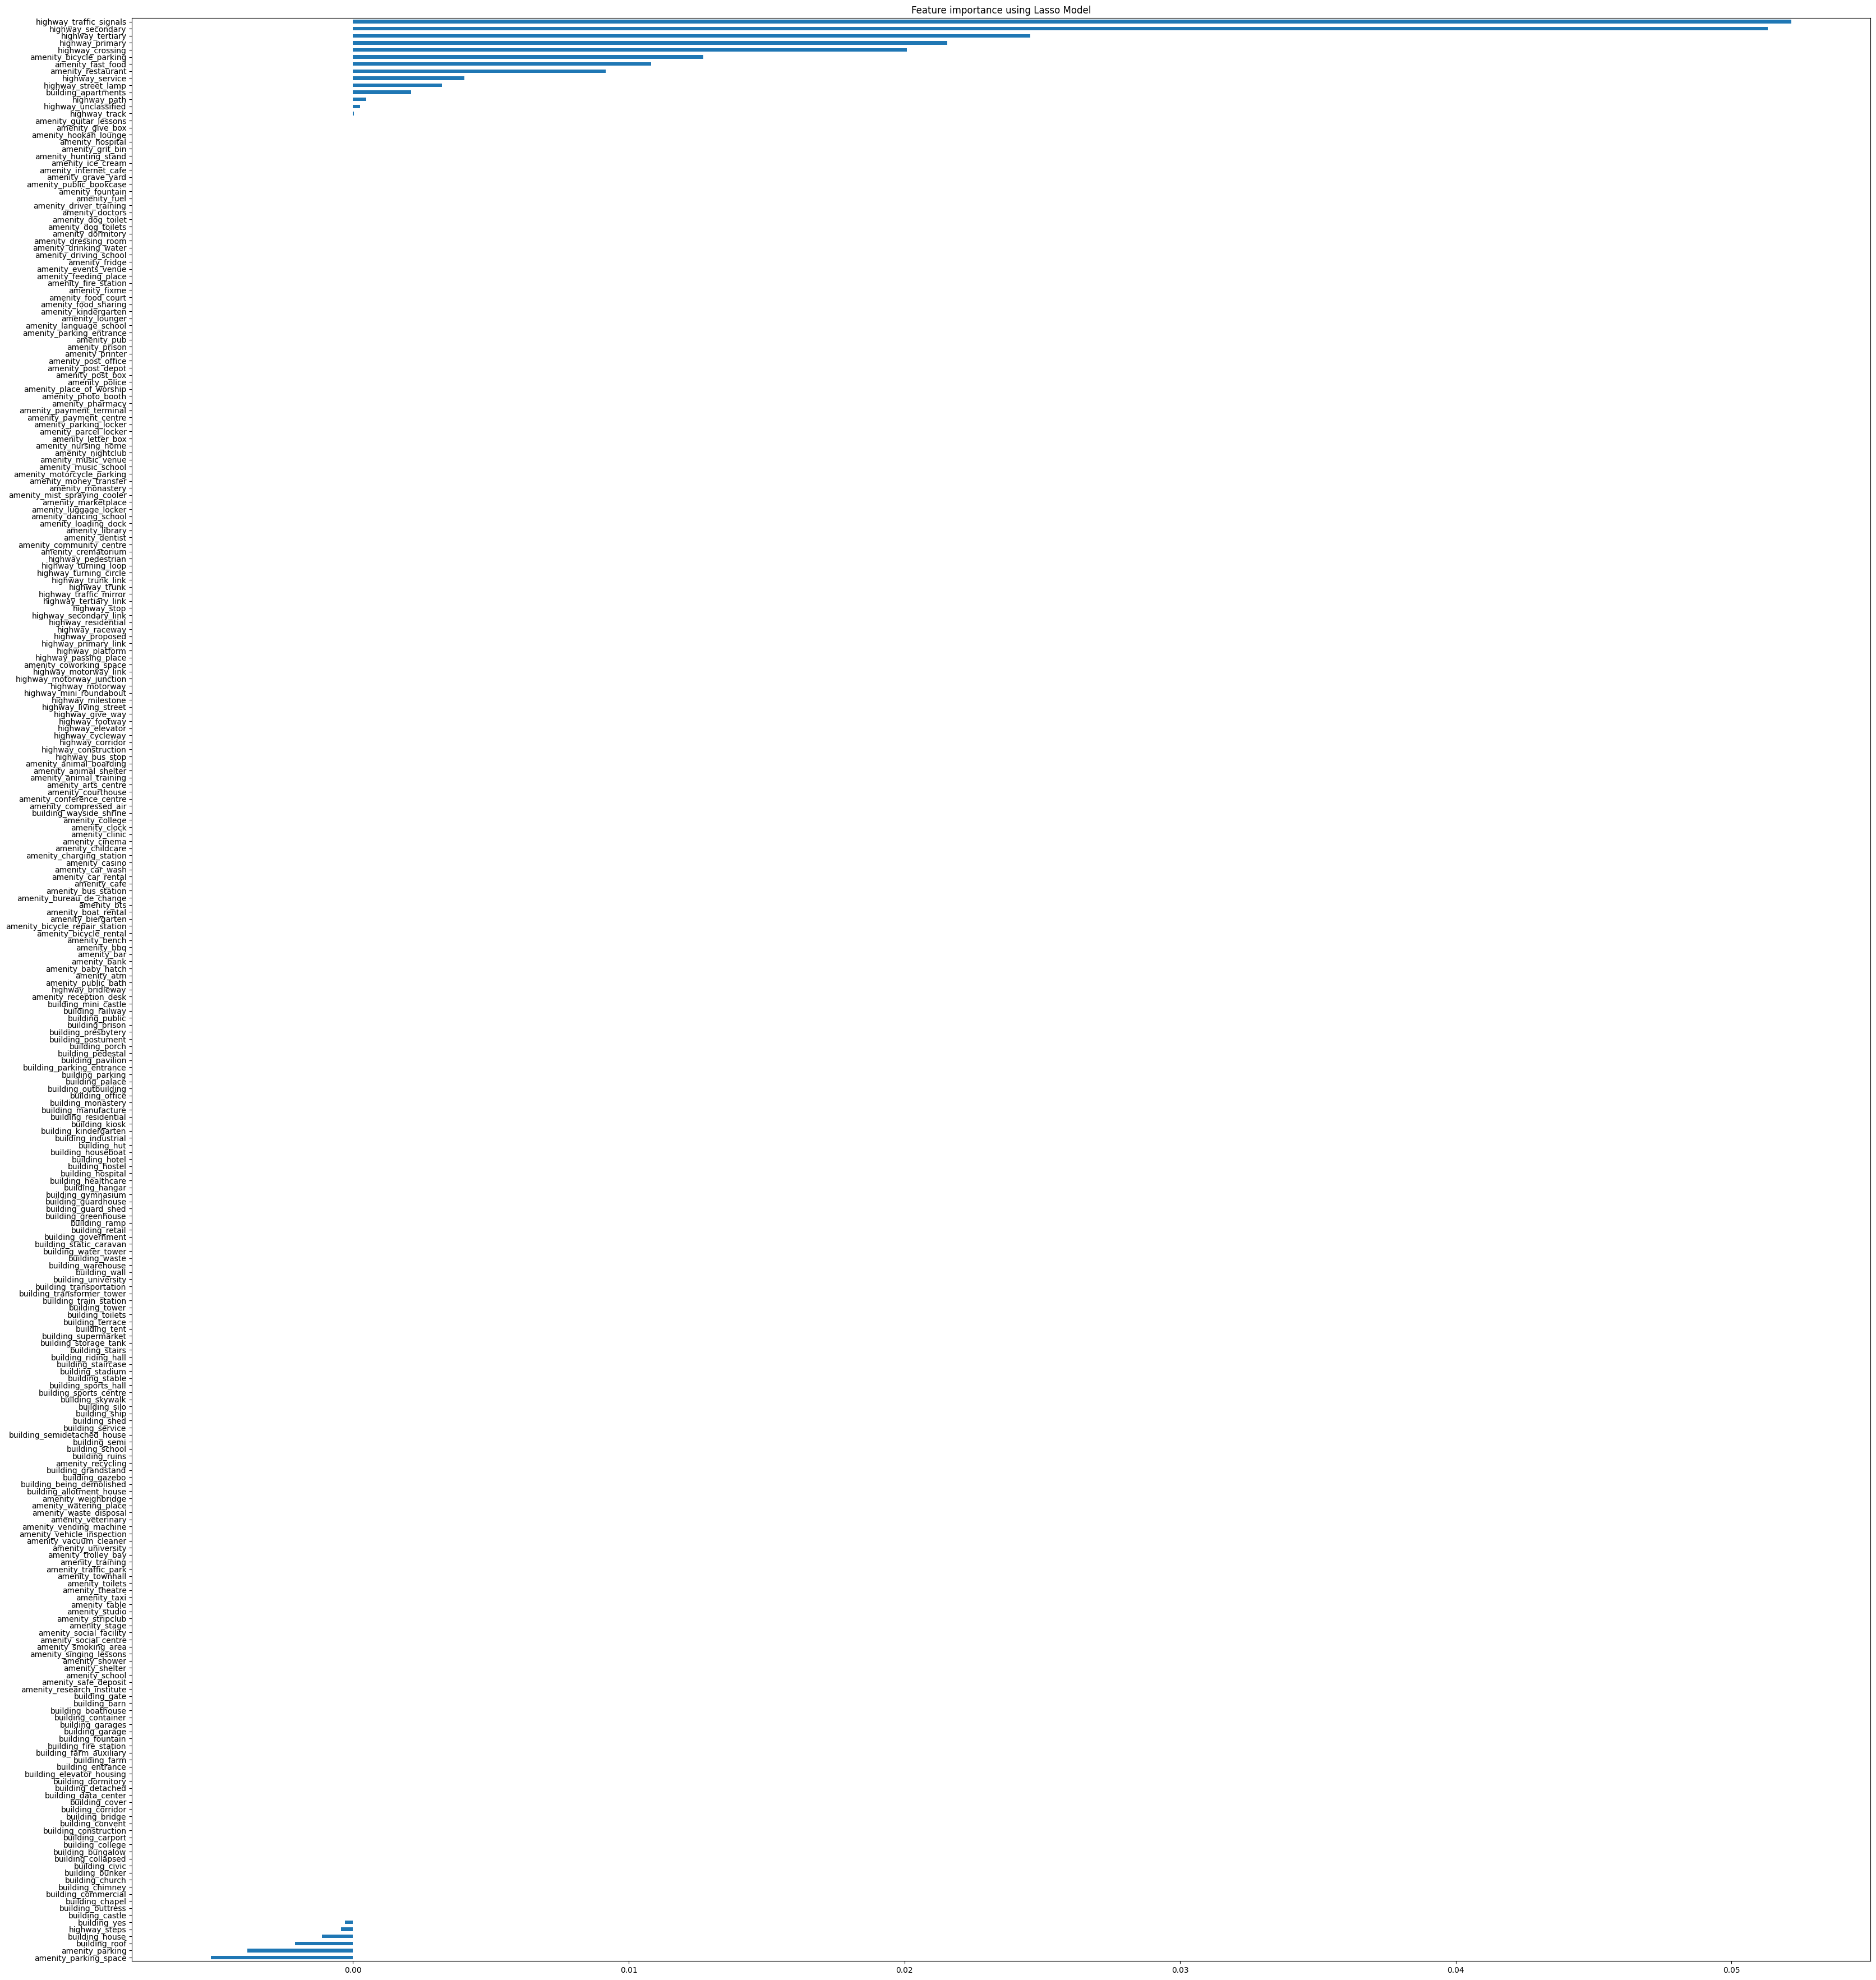

In [28]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (40.0, 45.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [29]:
# Cechy wytypowane do analizy przez lasso linear model
selected_columns = list(imp_coef.head(sum(coef != 0)).index)
print(selected_columns)

['amenity_parking_space', 'amenity_parking', 'building_roof', 'building_house', 'highway_steps', 'building_yes', 'building_castle', 'building_buttress', 'building_chapel', 'building_commercial', 'building_chimney', 'building_church', 'building_bunker', 'building_civic', 'building_collapsed', 'building_bungalow', 'building_college', 'building_carport', 'building_construction', 'building_convent']


In [30]:
X_filtered = X[selected_columns]
X_filtered.head()

,amenity_parking_space,amenity_parking,building_roof,building_house,highway_steps,building_yes,building_castle,building_buttress,building_chapel,building_commercial,building_chimney,building_church,building_bunker,building_civic,building_collapsed,building_bungalow,building_college,building_carport,building_construction,building_convent
region_id,,,,,,,,,,,,,,,,,,,,
891e2042a27ffff,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
891e2042b6bffff,0,3,0,0,5,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0
891e2047237ffff,0,1,1,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0
891e2042c57ffff,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
891e2051867ffff,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split( X_filtered, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_f = scaler.fit_transform(X_train_f)
X_test_f = scaler.transform (X_test_f)

#### DecisionTreeClassifier

In [33]:
y_class_counts

wypadki_category
0    2717
1     134
2      83
3      31
Name: count, dtype: int64

In [34]:
# wyznaczanie wag n_samples_all /( n_samples_class * n_classes)
n_samples_all = 2717 + 134 + 83 + 31
w0 = n_samples_all / (2717 * 4)
w1 = n_samples_all / (134 * 4)
w2 = n_samples_all / (83 * 4)
w3 = n_samples_all / (31 * 4)

custom_weights = {0: w0, 1: w1, 2: w2, 3: w3}

In [35]:
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [100, 200, 300, 400]
min_samples_leaf = [2, 5, 10]
max_features = [10, 20, 100, 500]
class_weights = [None, 'balanced', custom_weights]
clf = DecisionTreeClassifier()


In [36]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline(steps=['clf', clf])
params = [{
    "criterion": criterion,
    "max_features": max_features,
    "splitter": splitter,
    "min_samples_leaf": min_samples_leaf,
    "max_depth": max_depth, 
    "class_weight": class_weights
}]
gridCV = GridSearchCV(clf, params, cv=10, scoring= 'f1_micro')

In [37]:
gridCV.fit(X_train_f, y_train_f)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid=[{'class_weight': [None, 'balanced',
                                           {0: 0.2728192859771807,
                                            1: 5.531716417910448,
                                            2: 8.930722891566266,
                                            3: 23.911290322580644}],
                          'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [100, 200, 300, 400],
                          'max_features': [10, 20, 100, 500],
                          'min_samples_leaf': [2, 5, 10],
                          'splitter': ['best', 'random']}],
             scoring='f1_micro')

In [38]:
best_params = gridCV.best_params_
best_params

{'class_weight': None,
 'criterion': 'log_loss',
 'max_depth': 200,
 'max_features': 500,
 'min_samples_leaf': 5,
 'splitter': 'random'}

In [39]:
best_score_train = gridCV.best_estimator_.score(X_train_f, y_train_f)
best_score_train

0.9198988195615514

In [40]:
best_score_test = gridCV.best_estimator_.score(X_test_f, y_test_f)
best_score_test

0.9072512647554806

In [41]:
clf_best = DecisionTreeClassifier(criterion=best_params['criterion'],
                                   max_depth=best_params['max_depth'], 
                                   min_samples_leaf=best_params['min_samples_leaf'],
                                   max_features=best_params['max_features'],
                                   splitter=best_params['splitter'],
                                   class_weight=custom_weights)
clf_best.fit(X_train_f, y_train_f)
y_pred = clf_best.predict(X_test_f)


              precision    recall  f1-score   support

           0       0.98      0.71      0.82       543
           1       0.07      0.28      0.11        29
           2       0.05      0.21      0.08        14
           3       0.08      0.29      0.12         7

    accuracy                           0.67       593
   macro avg       0.29      0.37      0.28       593
weighted avg       0.91      0.67      0.76       593



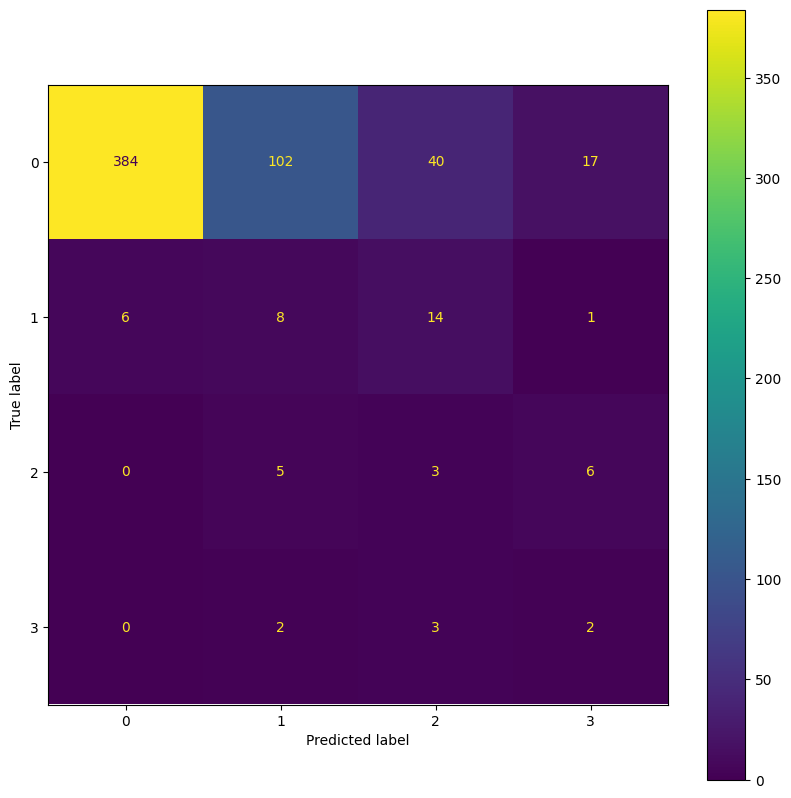

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
class_report = classification_report(y_test_f, y_pred)
print(class_report)
conf_matrix = confusion_matrix(y_test_f, y_pred, labels=clf_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=clf_best.classes_)
disp.plot()
plt.show()